# 1. Introduction

# 1.1 Overview

Use of exploratory data analysis to generate insights for a Microsoft Stakeholder.

## 1.2 Business Understanding

What is the Real World Problem?
Microsoft has seen all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. The task at hand is exploring what types of films are currently doing the best at the box office. 

Who can use the project and how?
The data will be used by the head of Microsoft's new movie studio to help decide what type of films to create.

# 2. Data Understanding

## 2.1 Sources and Properties of Data

The folder containing the data is called "zippedData" which contains movie datasets from:

1. Box Office Mojo

2. IMDB

3. Rotten Tomatoes

4. TheMovieDB

5. The Numbers

The files are in different formats that is, CSV and TSV files and can be opened using the pd.read_csv.
Data from IMDB is in a SQLite Database. 

The data files used in the analysis are:

1. im.db.zip which is a Zipped SQLite database (It needs to be unziped then queried using SQLite). The relevant tables are movie_basics and movie_ratings.

2. bom.movie_gross.csv.gz - a compressed CSV file

3. tn.movie_budgets.csv.gz - a compressed CSV file

4. tmdb.movies.csv.gz - a compressed CSV file

We will not use the data from the TSV files because they don't have the data we need in analysing. We will only use the compressed CSV files and unzipped IMDB file.

Our final dataset to be used in the analysis is named "movies_df". The size of the dataset is 1001 by 10 (1001 rows by 10 columns). The columns are:

1. movie - name of film

2. runtime_minutes - total minutes of a film

3. genres - types of films

4. averagerating - average rating of individual films

5. production_budget - total production budget for the film

6. month - release month of the film

7. profit - total amount remainint production budget from total gross

8. original_language - film language

9. popularity - how popular a film is

10. year - release year of film

These columns are relevant in analysing what impact genres, language and release month have on films in order to make conclusions and recommendations.
In order to make recommendations this analysis is going to explore some questions which are:
1. What types of films are doing the best at the box office?

2. Which languages are doing the best at the box office?

3. Does Release month affect profit?

4. Is there a correlation between runtime minutes and the other variables?

## 2.2 Loading Libraries

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import shutil
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

## 2.3 Loading Datasets

In [2]:
# Unpacking the imdb file
shutil.unpack_archive("im.db.zip")

#Creating a connection
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [3]:
# Fetching table names
cur.execute(""" SELECT name FROM sqlite_master WHERE type='table';""")
tables = cur.fetchall()

In [4]:
# Loading csv datasets
budget_df = pd.read_csv("tn.movie_budgets.csv.gz")
votes_df = pd.read_csv("tmdb.movies.csv.gz", index_col=0)
gross_df = pd.read_csv("bom.movie_gross.csv.gz")

#loading the sql tables datasets 
basics_df = pd.read_sql("""SELECT * FROM movie_basics;""", conn)
ratings_df = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)

## 2.4 Exploring Datasets

In [5]:
# the first 2 values in the budget dataset
budget_df.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [6]:
# Information about the dataset i.e., number of rows and columns, column names, missing values and datatype
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
# Shape of the dataset in terms of number of rows and columns
budget_df.shape

(5782, 6)

The budget dataset has 5782 rows and 6 columns

In [8]:
votes_df.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [9]:
votes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [10]:
votes_df.shape

(26517, 9)

The votes dataset has 26517 rows and 9 columns.

In [11]:
gross_df.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [12]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [13]:
gross_df.shape

(3387, 5)

The gross dataset has 3387 rows and 5 columns.

In [14]:
basics_df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [15]:
basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [16]:
basics_df.shape

(146144, 6)

The basics dataset has 146144 rows and 6 columns

In [17]:
ratings_df.head(2)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [19]:
ratings_df.shape

(73856, 3)

The ratings dataset has 73856 rows and 3 columns

# 3. Data Preparation

## Data Cleaning

Data cleaning is the process of preparing data for analysis by weeding out information that is irrelevant or incorrect.This is generally data that can have a negative impact on the model or algorithm it is fed into by reinforcing a wrong notion. Data cleaning not only refers to removing chunks of unnecessary data, but it’s also often associated with fixing incorrect information within the train-validation-test dataset and reducing duplicates.
We will analyse each dataset separately because we have 5 datasets to start with. The steps for our data cleaning is:

1. Completeness - Ensure the datasets has no missing values.

2. Uniformity - The datatypes for the datasets are correct.

3. Consistency - Ensure there are no duplicates in the data.


## 3.1 Budget Dataset

In [20]:
# Datatypes of the dataset should be correct but first we need to know them
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The datatype for release date should be in pandas date format.
The datatype for production budget, domestic gross and worldwide gross should be an integer.

In [21]:
# Format the date into the pandas date format
budget_df['release_date'] = pd.to_datetime(budget_df['release_date'])

In [22]:
# I want to operate on multiple columns hence put them in a list:
budget_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

# pass them to df.replace(), specifying each char and it's replacement:
budget_df[budget_cols] = budget_df[budget_cols].replace({'\$': '', ',': ''}, regex=True)

In [23]:
# Convert the budget and gross columns into the integer datatype
budget_df[budget_cols] = budget_df[budget_cols].astype(np.int64)

In [24]:
# Check to see if the values for the columns have been converted to the necessary datatypes
budget_df.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


In [25]:
# Checking for duplicates in the dataset
budget_df.duplicated().sum()

0

No duplicates in the dataset.

In [26]:
budget_df.duplicated(["movie","release_date"]).sum()

0

No duplicates in the movie and release date columns.

In [27]:
# Checking for missing values
budget_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

The dataset has no missing values

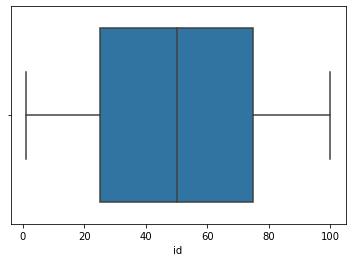

In [28]:
# Checking for outliers in our dataset
sns.boxplot(data=budget_df, x="id");

No outliers in the ID column

## 3.2 Votes Dataset

In [29]:
# We will look at the votes dataset as we did above with the budget dataset
votes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [30]:
# Format the date into the pandas date format
votes_df['release_date'] = pd.to_datetime(votes_df['release_date'])

In [31]:
votes_df.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [32]:
# Checking for duplicates in the dataset
votes_df.duplicated().sum()

1020

In [33]:
# Remove the duplicates
votes_df.drop_duplicates(keep="first", inplace=True)

In [34]:
# Confirming that the duplicates have been removed
votes_df.duplicated().sum()

0

In [35]:
#Checking for duplicates in the title column
votes_df.duplicated(["title","release_date"]).sum()

7

In [36]:
votes_df.drop_duplicates(["title","release_date"], keep="first", inplace=True)

In [37]:
votes_df.duplicated(["title","release_date"]).sum()

0

In [38]:
# Checking for missing values
votes_df.isna().sum()

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

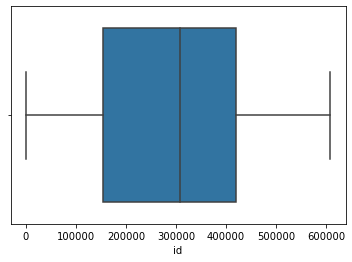

In [39]:
# Checking for outliers in our dataset
sns.boxplot(data=votes_df, x="id");

## 3.3 Gross Dataset

In [40]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [41]:
gross_df.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [42]:
# removing the quotations and commas in the foreign gross column
gross_df["foreign_gross"] = gross_df["foreign_gross"].replace({"''": "", ",": ""}, regex=True)

In [43]:
# Changing the datatype from object to float
gross_df["foreign_gross"] = gross_df["foreign_gross"].astype(float)

In [44]:
# Check for duplicates
gross_df.duplicated().sum()

0

In [45]:
# Check for duplicates in the title column
gross_df.duplicated(["title","year"]).sum()

0

In [46]:
# Check for missing values 
gross_df.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

There are 5 missing values in the studio column, 28 in the domestic gross column and 1350 in the foreign gross column.

In [47]:
# We will drop the rows with missing values in the studio column
gross_df = gross_df.dropna(subset=['studio'])

In [48]:
# We will replace the missing values in the domestic gross column with their mean
gross_df["domestic_gross"].fillna(gross_df["domestic_gross"].mean(), inplace=True)

In [49]:
# We will drop the rows with missing values in the foreign gross column
gross_df = gross_df.dropna(subset=['foreign_gross'])

In [50]:
gross_df.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

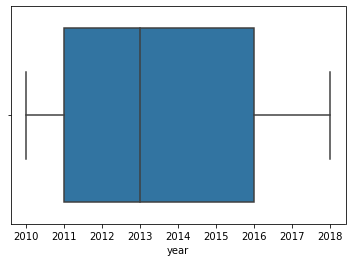

In [51]:
# Check for outliers in the data
sns.boxplot(data=gross_df, x="year");

There are no missing values or outliers in this dataset. We can proceed to the next dataset.

## 3.4 Basics Dataset

In [52]:
basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [53]:
basics_df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [54]:
basics_df.nunique()

movie_id           146144
primary_title      136071
original_title     137773
start_year             19
runtime_minutes       367
genres               1085
dtype: int64

In [55]:
#Check for duplicates
basics_df.duplicated().sum()

0

In [56]:
# Check for duplicates in the primary title column
basics_df.duplicated(["primary_title","start_year"]).sum()

2072

In [57]:
# drop the duplicates in the primary title column
basics_df.drop_duplicates(["primary_title","start_year"], keep="first", inplace=True)

In [58]:
# Check for duplicates in the primary title column
basics_df.duplicated(["primary_title","start_year"]).sum()

0

In [59]:
# Check for missing values 
basics_df.isna().sum()

movie_id               0
primary_title          0
original_title        18
start_year             0
runtime_minutes    31218
genres              5192
dtype: int64

In [60]:
# We will drop the original title column because there is a primary title column
basics_df = basics_df.drop('original_title', axis = 1)

In [61]:
# We will drop the rows with missing values in the genres column
basics_df = basics_df.dropna(subset=['genres'])

In [62]:
# Drop the rows with missing values in the runtime minutes column
basics_df = basics_df.dropna(subset=['runtime_minutes'])

In [63]:
# Check for any more missing values
basics_df.isna().sum()

movie_id           0
primary_title      0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

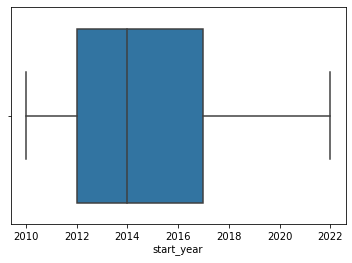

In [64]:
# Check for outliers in the data
sns.boxplot(data=basics_df, x="start_year");

There are no outliers in the dataset. We can proceed to the next.

## 3.5 Ratings Dataset

In [65]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [66]:
ratings_df.head(2)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [67]:
#Check for duplicates
ratings_df.duplicated().sum()

0

In [68]:
# Check for duplicates in the movie id column
ratings_df.duplicated(["movie_id"]).sum()

0

No duplicates in the movie id column or the ratings dataset.

In [69]:
# Check for missing values in the ratings dataset
ratings_df.isna().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

No missing values in this dataset.

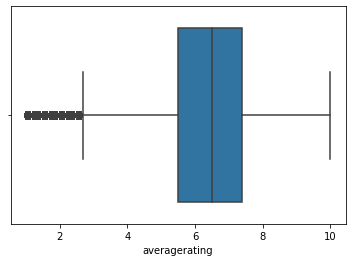

In [70]:
# Check for outliers in the data
sns.boxplot(data=ratings_df, x="averagerating");

These outliers can be ignored here.

## 3.6 Merging Datasets

In [71]:
# Explore the new cleaned datsets so that we can know how to merge them
basics_df.head(2)

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"


In [72]:
basics_df.shape

(110725, 5)

In [73]:
ratings_df.head(2)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [74]:
ratings_df.shape

(73856, 3)

In [75]:
votes_df.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [76]:
votes_df.shape

(25490, 9)

In [77]:
gross_df.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010


In [78]:
gross_df.shape

(2033, 5)

In [79]:
budget_df.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


In [80]:
budget_df.shape

(5782, 6)

In [81]:
# Merge the basics and ratings dataset using the movie id column
basics_and_ratings_df = basics_df.merge(ratings_df, on="movie_id", how="inner")

# Confirm the necessary columns are in the new dataset 
basics_and_ratings_df.head(2)

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43


In [82]:
# Merge the votes and gross dataset using the title column
votes_and_gross_df = votes_df.merge(gross_df, on="title", how="inner")

# Confirm the necessary columns are in the new dataset 
votes_and_gross_df.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year
0,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000.0,2010
1,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000.0,2010


In [83]:
# The only dataset not merged is the budget dataset so explore this again
budget_df.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


In [84]:
# Drop columns not needed in the exploratory analysis
# In the basics and ratings merged dataset we will drop the number of votes, movie id, start year
basics_and_ratings_df.drop(["numvotes","movie_id","start_year"], axis = 1, inplace = True)

In [85]:
# In the votes and gross merged dataset we will drop the original title and genre ids
votes_and_gross_df.drop(["genre_ids","original_title"], axis = 1, inplace = True)

In [86]:
# Check for duplicates in our merged datasets
basics_and_ratings_df.duplicated(["primary_title"]).sum()

2669

In [87]:
# We should drop the duplicates
basics_and_ratings_df.drop_duplicates(["primary_title"], keep='first', inplace=True)

In [88]:
# Check for duplicates 
votes_and_gross_df.duplicated(["title"]).sum()

97

In [89]:
# We should drop the duplicates
votes_and_gross_df.drop_duplicates(["title"], keep='first', inplace=True)

In [90]:
# Confirm if there are duplicates
votes_and_gross_df.duplicated(["title"]).sum()

0

We have no duplicates

In [91]:
#Now we add columns we want to work with using the columns we have
# 1. We will not add anything to the basics and ratings merged dataset
# 2. We can now drop the domestic gross, foreign gross and release dates column

In [92]:
votes_and_gross_df.drop(["domestic_gross","foreign_gross","release_date"], axis = 1, inplace = True)

In [93]:
# 3. We will add a column for total gross in the budget dataframe and another column for release month extracted 
#     from the release date
#    We will also add another column for profit

In [94]:
budget_df["total_gross"] = budget_df["domestic_gross"] + budget_df["worldwide_gross"] 

In [95]:
budget_df["month"] = budget_df["release_date"].dt.month

In [96]:
budget_df["profit"] = budget_df["total_gross"] - budget_df["production_budget"] 

In [97]:
# We can now drop the domestic gross, worldwide gross, id and release dates column
budget_df.drop(["domestic_gross","worldwide_gross","total_gross","release_date","id"], axis = 1, inplace = True)

In [98]:
# merge the basics and ratings dataset with the budget dataset
# 1. Change the primary title column in basics and ratings dataset to "movie"
basics_and_ratings_df.columns = ["movie","runtime_minutes","genres","averagerating"]
basics_and_ratings_df.head(2)

,movie,runtime_minutes,genres,averagerating
0,Sunghursh,175.0,"Action,Crime,Drama",7.0
1,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2


In [99]:
# 2. Now merge the two datasets using the movie column
basics_and_budget_df = basics_and_ratings_df.merge(budget_df, on="movie", how="inner")
basics_and_budget_df.head(2)

,movie,runtime_minutes,genres,averagerating,production_budget,month,profit
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,45000000,12,-44926294
1,On the Road,124.0,"Adventure,Drama,Romance",6.1,25000000,3,-14965870


In [100]:
# Drop the unneccessary columns
votes_and_gross_df.drop(["id","vote_average", "vote_count","studio"], axis = 1, inplace = True)

In [101]:
# Confirm the columns for the new dataset 
votes_and_gross_df.head(2)

,original_language,popularity,title,year
0,en,28.734,How to Train Your Dragon,2010
1,en,28.515,Iron Man 2,2010


In [102]:
# merge the basics and budget dataset with the votes and gross dataset
# 1. Change the title column in votes and gross dataset to "movie"
votes_and_gross_df.columns = ["original_language","popularity","movie","year"]
votes_and_gross_df.head(2)

,original_language,popularity,movie,year
0,en,28.734,How to Train Your Dragon,2010
1,en,28.515,Iron Man 2,2010


In [103]:
# 2. Merge the two datasets into the final dataset using the movie column
movies = basics_and_budget_df.merge(votes_and_gross_df, on="movie", how="inner")
movies.head(2)

,movie,runtime_minutes,genres,averagerating,production_budget,month,profit,original_language,popularity,year
0,On the Road,124.0,"Adventure,Drama,Romance",6.1,25000000,3,-14965870,en,8.919,2012
1,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,91000000,12,155098021,en,10.743,2013


In [104]:
# Sort movies dataset by year from the most current year
movies_df = movies.sort_values('year', ascending=False)

Now that we have all the needed columns let us explore the movie dataset before we do the visualizations.

In [105]:
movies_df.head(2)

,movie,runtime_minutes,genres,averagerating,production_budget,month,profit,original_language,popularity,year
364,Aquaman,143.0,"Action,Adventure,Fantasy",7.1,160000000,12,1321956447,en,38.102,2018
568,Life of the Party,84.0,"Comedy,Drama",7.6,30000000,5,88819822,en,13.696,2018


In [106]:
movies_df.shape

(1001, 10)

# 4. Data Analysis

## 4.1 Genres

### 4.1.1 Most Profitable Genres

In [107]:
# Create a new dataset with the profit column arranged from highest to lowest
high_profit_genre = movies_df.sort_values('profit', ascending = False).head(250)

In [108]:
# Create an empty list
genre = []

# Split genres in the rows
for genres in high_profit_genre["genres"]:
    # split all
    genre.append(genres.split(','))

# Create another empty list
genres_list = []

#Accessing the individual genres in the rows
for i in genre:
    for item in i:
        genres_list.append(item)

# Count the number of films by genre
genres_sum = Counter(genres_list)

# Arrange them from the most common to least common
genres_sum.most_common()

[('Adventure', 149),
 ('Action', 127),
 ('Comedy', 88),
 ('Drama', 56),
 ('Animation', 53),
 ('Sci-Fi', 50),
 ('Thriller', 37),
 ('Fantasy', 25),
 ('Crime', 20),
 ('Mystery', 17),
 ('Family', 16),
 ('Biography', 15),
 ('Romance', 14),
 ('Horror', 12),
 ('Music', 4),
 ('History', 4),
 ('Sport', 3),
 ('Western', 2),
 ('Documentary', 1),
 ('Musical', 1)]

The top 5 most profitable genres are Adventure, Action, Comedy, Drama and Animation.
This is visualized below using a bar chart.

In [109]:
# Create two empty lists for genres and the number of movies
genres = []
Number_of_Movies = []

# Use a for loop to access the key value pairs in the genres sum dictionary
for key, values in genres_sum.items():
    genres.append(key)
    Number_of_Movies.append(values)

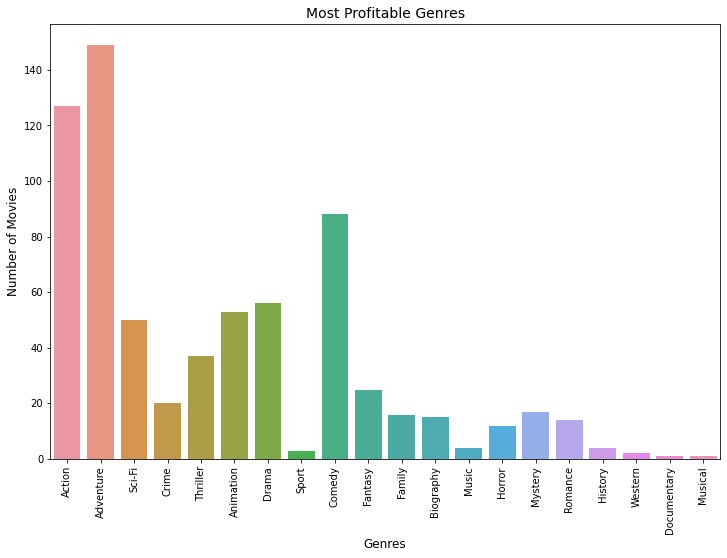

In [110]:
# Plot the above data into a barplot using sns
# Defining figure size for the output plot
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(genres, Number_of_Movies)

# Labelling the graph
ax.set_title('Most Profitable Genres', fontsize=14)
ax.set_xlabel("Genres",fontsize=12)
ax.set_ylabel("Number of Movies", fontsize=12);

# Setting ticks on the x axis
ax.set_xticklabels(labels = genres, rotation = 90)

#Save the image
fig.savefig('Most Profitable Genres.png');

### 4.1.2 Highest Budget Genres

In [111]:
# Create a new dataset with the budget column arranged from highest to lowest
high_budget_genre = movies_df.sort_values('production_budget', ascending = False).head(250)

In [112]:
# Repeat the steps from the most profitable genres
genre = []

for genres in high_budget_genre["genres"]:
    genre.append(genres.split(','))
    
genres_list = []

for i in genre:
    for item in i:
        genres_list.append(item)
        
genres_sum = Counter(genres_list)

genres_sum.most_common()

[('Adventure', 187),
 ('Action', 158),
 ('Comedy', 81),
 ('Animation', 58),
 ('Sci-Fi', 51),
 ('Drama', 46),
 ('Fantasy', 40),
 ('Thriller', 28),
 ('Family', 26),
 ('Crime', 14),
 ('Mystery', 9),
 ('Horror', 5),
 ('Romance', 5),
 ('History', 4),
 ('Biography', 4),
 ('Western', 2),
 ('Musical', 2),
 ('Sport', 1)]

The top 5 most highest budget genres are Adventure, Action, Comedy Animation and Sci-Fi.
This is visualized below using a bar chart.

In [113]:
genres = []
Number_of_Movies = []

for key, values in genres_sum.items():
    genres.append(key)
    Number_of_Movies.append(values)

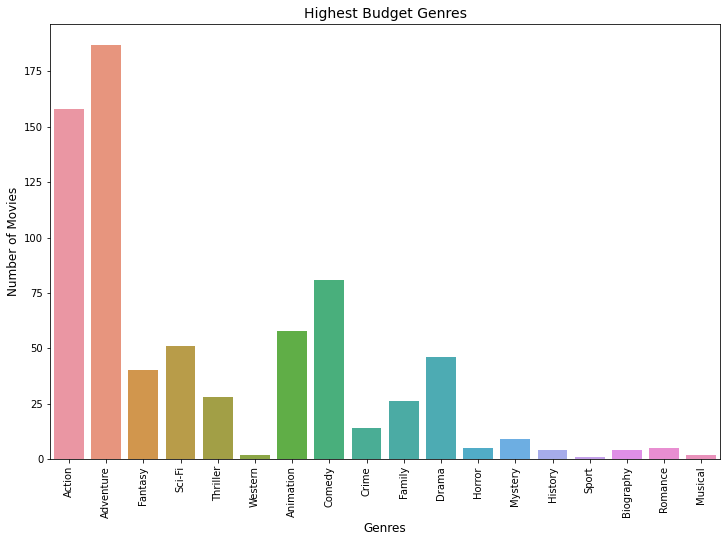

In [114]:
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(genres, Number_of_Movies)

ax.set_title('Highest Budget Genres', fontsize=14)
ax.set_xlabel("Genres",fontsize=12)
ax.set_ylabel("Number of Movies", fontsize=12);

ax.set_xticklabels(labels = genres, rotation = 90)
fig.savefig('Highest Budget Genres.png');

### 4.1.3 Most Popular Genres

In [115]:
# Create a new dataset with the popularity column arranged from highest to lowest
most_watched_genre = movies_df.sort_values('popularity', ascending = False).head(250)

In [116]:
genre = []

for genres in most_watched_genre["genres"]:
    # split all
    genre.append(genres.split(','))
    
genres_list = []

for i in genre:
    for item in i:
        genres_list.append(item)
        
genres_sum = Counter(genres_list)

genres_sum.most_common()

[('Action', 143),
 ('Adventure', 130),
 ('Drama', 74),
 ('Comedy', 59),
 ('Sci-Fi', 54),
 ('Thriller', 50),
 ('Crime', 37),
 ('Fantasy', 33),
 ('Animation', 30),
 ('Mystery', 27),
 ('Horror', 17),
 ('Biography', 16),
 ('Family', 15),
 ('Romance', 8),
 ('History', 5),
 ('Music', 3),
 ('Sport', 2),
 ('Documentary', 1),
 ('Musical', 1),
 ('Western', 1)]

The top 5 most popular genres are Action, Adventure, Drama, Comedy and Sci-Fi.
This is visualized below using a bar chart.

In [117]:
genres = []
Number_of_Movies = []

for key, values in genres_sum.items():
    genres.append(key)
    Number_of_Movies.append(values)

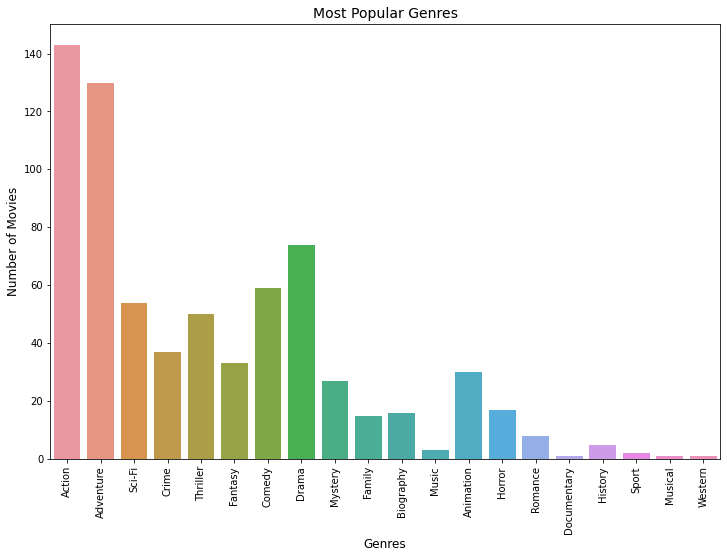

In [118]:
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(genres, Number_of_Movies)

ax.set_title('Most Popular Genres', fontsize=14)
ax.set_xlabel("Genres",fontsize=12)
ax.set_ylabel("Number of Movies", fontsize=12);

ax.set_xticklabels(labels = genres, rotation = 90)
fig.savefig('Most Popular Genres.png');

### 4.1.4 Highest Rated Genres

In [119]:
# Create a new dataset with the profit rating arranged from highest to lowest
highly_rated_genre = movies_df.sort_values('averagerating', ascending = False).head(250)

In [120]:
genre = []

for genres in highly_rated_genre["genres"]:
    # split all
    genre.append(genres.split(','))
    
genres_list = []

for i in genre:
    for item in i:
        genres_list.append(item)
        
genres_sum = Counter(genres_list)

genres_sum.most_common()

[('Drama', 167),
 ('Action', 69),
 ('Adventure', 68),
 ('Comedy', 68),
 ('Biography', 51),
 ('Crime', 41),
 ('Thriller', 36),
 ('Sci-Fi', 29),
 ('Animation', 27),
 ('Romance', 25),
 ('Mystery', 18),
 ('History', 16),
 ('Fantasy', 12),
 ('Sport', 9),
 ('Family', 8),
 ('Music', 6),
 ('Horror', 6),
 ('Documentary', 3),
 ('War', 3),
 ('Western', 2),
 ('Musical', 1)]

The top 5 highest rated genres are Drama, Action, Adventure, Comedy and Biography.
This is visualized below using a bar chart.

In [121]:
genres = []
Number_of_Movies = []

for key, values in genres_sum.items():
    genres.append(key)
    Number_of_Movies.append(values)

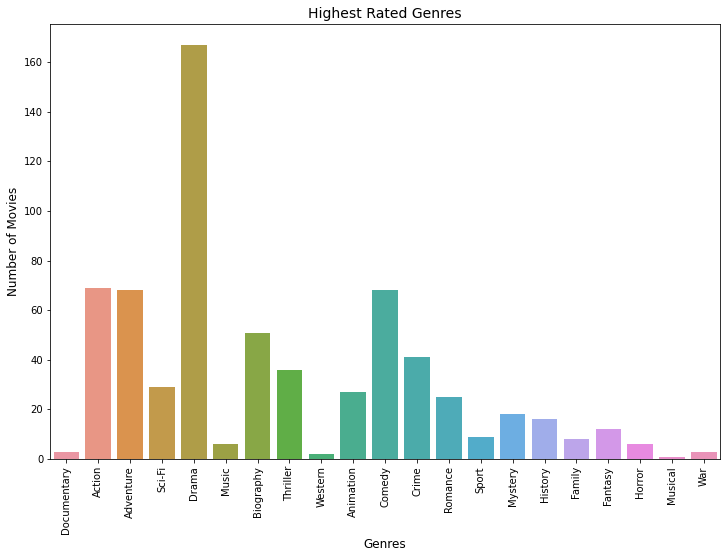

In [122]:
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(genres, Number_of_Movies)

ax.set_title('Highest Rated Genres', fontsize=14)
ax.set_xlabel("Genres",fontsize=12)
ax.set_ylabel("Number of Movies", fontsize=12);

ax.set_xticklabels(labels = genres, rotation = 90)
fig.savefig('Highest Rated Genres.png');

## 4.2 Original Language

### 4.2.1 Most Profitable Languages

In [123]:
# accessing the highest profit of the movies per month

high_profit = movies_df.groupby('original_language')['profit'].mean()

# Converting it back to a dataframe
high_profit_lang = pd.DataFrame(high_profit)
high_profit_lang.reset_index(drop=False, inplace=True)

In [124]:
# Arranging from highest to lowest
high_profit_lang.sort_values('profit', ascending=False)

,original_language,profit
10,th,6.068887e+08
9,te,2.524887e+08
3,en,2.019697e+08
7,hu,1.301907e+08
6,hi,1.009808e+08
2,el,8.447625e+07
8,ko,1.978070e+07
0,da,1.544815e+07
5,fr,1.335976e+07
1,de,3.298326e+06


The top 5 most profitable languages are Thai, Telugu, English, Hungarian and Hindi.
This is visualized below using a bar chart.

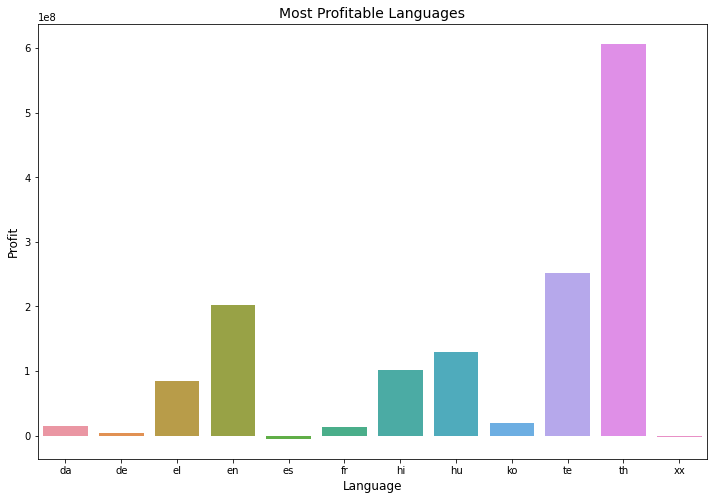

In [125]:
# plotting the data above

fig, ax = plt.subplots(figsize=(12,8))

x = high_profit_lang['original_language']
y = high_profit_lang['profit']

sns.barplot(x , y)

ax.set_title('Most Profitable Languages', fontsize=14)
ax.set_xlabel("Language",fontsize=12)
ax.set_ylabel("Profit", fontsize=12)

fig.savefig('Most Profitable Languages.png');

### 4.2.2 Most Popular Languages

In [126]:
most_pop = movies_df.groupby('original_language')['popularity'].mean()


most_pop_lang = pd.DataFrame(most_pop)
most_pop_lang.reset_index(drop=False, inplace=True)

In [127]:
most_pop_lang.sort_values('popularity', ascending=False)

,original_language,popularity
3,en,14.164238
0,da,11.123000
9,te,10.406000
8,ko,8.067500
6,hi,7.626000
5,fr,7.595250
1,de,5.577000
4,es,4.148500
2,el,0.840000
7,hu,0.600000


The top 5 most popular languages are English, Danish, Telugu, Korean and Hindi.
This is visualized below using a bar chart.

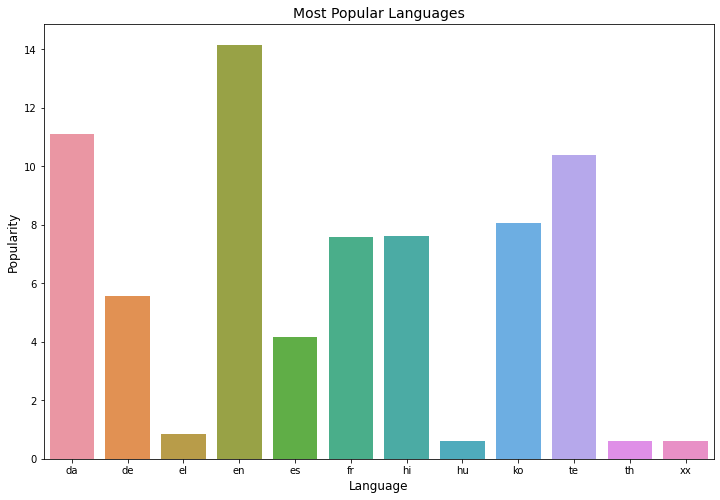

In [128]:
# plotting the data above

fig, ax = plt.subplots(figsize=(12,8))

x = most_pop_lang['original_language']
y = most_pop_lang['popularity']

sns.barplot(x , y)

ax.set_title('Most Popular Languages', fontsize=14)
ax.set_xlabel("Language",fontsize=12)
ax.set_ylabel("Popularity", fontsize=12)

fig.savefig('Most Popular Languages.png');

### 4.2.3 High Budget Languages

In [129]:
high_budget = movies_df.groupby('original_language')['production_budget'].mean()


high_budget_lang = pd.DataFrame(high_budget)
high_budget_lang.reset_index(drop=False, inplace=True)

In [130]:
high_budget_lang.sort_values('production_budget', ascending=False)

,original_language,production_budget
10,th,1.850000e+08
3,en,5.533714e+07
2,el,5.100000e+07
7,hu,3.100000e+07
9,te,3.000000e+07
8,ko,2.670000e+07
4,es,2.350000e+07
6,hi,1.423333e+07
0,da,9.400000e+06
5,fr,6.775000e+06


The top 5 high budget languages are Thai, English, Greek Modern, Hungarin and Telugu.
This is visualized below using a bar chart.

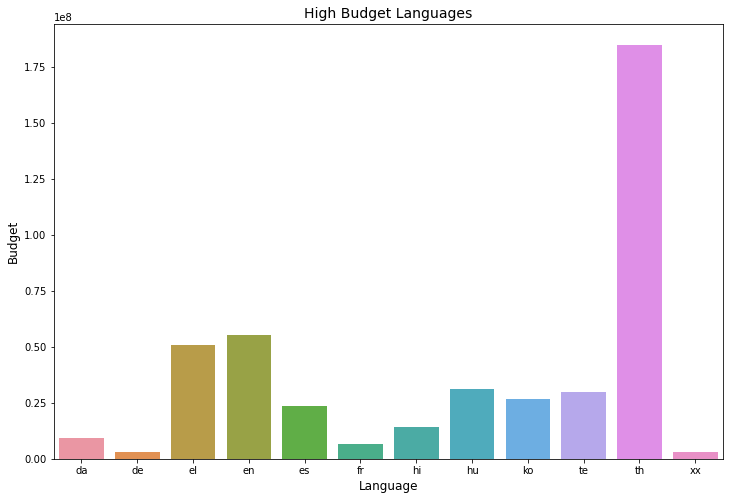

In [131]:
# plotting the data above
fig, ax = plt.subplots(figsize=(12,8))

x = high_budget_lang['original_language']
y = high_budget_lang['production_budget'] 

sns.barplot(x , y)

ax.set_title('High Budget Languages', fontsize=14)
ax.set_xlabel("Language",fontsize=12)
ax.set_ylabel("Budget", fontsize=12)

fig.savefig('High Budget Languages.png');

### 4.2.4 Highest Rated Languages

In [132]:
high_rated = movies_df.groupby('original_language')['averagerating'].mean()


high_rated_lang = pd.DataFrame(high_rated)
high_rated_lang.reset_index(drop=False, inplace=True)

In [133]:
high_rated_lang.sort_values('averagerating', ascending=False)

,original_language,averagerating
1,de,9.200000
9,te,8.300000
4,es,7.350000
5,fr,7.300000
0,da,7.200000
10,th,7.100000
6,hi,6.666667
3,en,6.457172
7,hu,6.100000
2,el,5.500000


The top 5 highest rated languages are German, Telugu, Spanish, French and Danish.
This is visualized below using a bar chart.

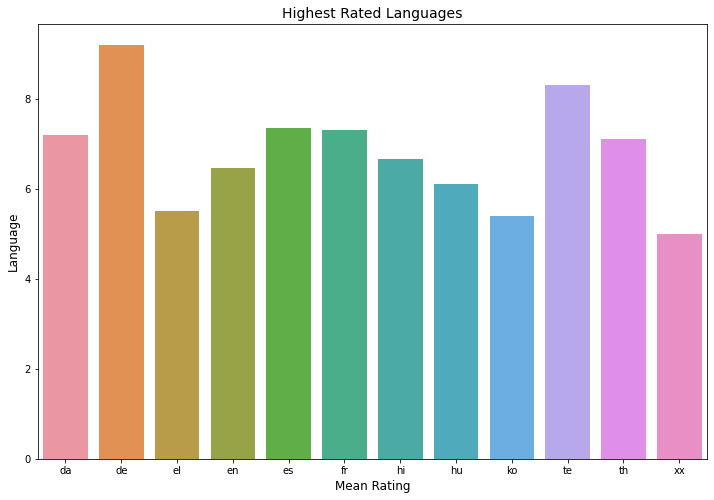

In [134]:
# plotting the data above

fig, ax = plt.subplots(figsize=(12,8))

x = high_rated_lang['original_language']
y = high_rated_lang['averagerating']

sns.barplot(x , y)

ax.set_title('Highest Rated Languages', fontsize=14)
ax.set_xlabel("Mean Rating",fontsize=12)
ax.set_ylabel("Language", fontsize=12)

fig.savefig('Highest Rated Languages.png');

## 4.3 Release Month

### 4.3.1 Months With Highest Profit

In [135]:
month_profit = movies_df.groupby('month')['profit'].mean()


monthly_profit_sum = pd.DataFrame(month_profit)
monthly_profit_sum.reset_index(drop=False, inplace=True)

In [136]:
monthly_profit_sum.sort_values('profit', ascending=False)

,month,profit
5,6,3.545209e+08
4,5,3.036656e+08
6,7,2.830663e+08
10,11,2.383476e+08
11,12,2.208219e+08
3,4,1.951843e+08
1,2,1.795434e+08
2,3,1.555171e+08
7,8,1.360648e+08
9,10,1.089971e+08


The top 3 most profitable months are June, May, July, November and December.
This is visualized below using a bar chart.

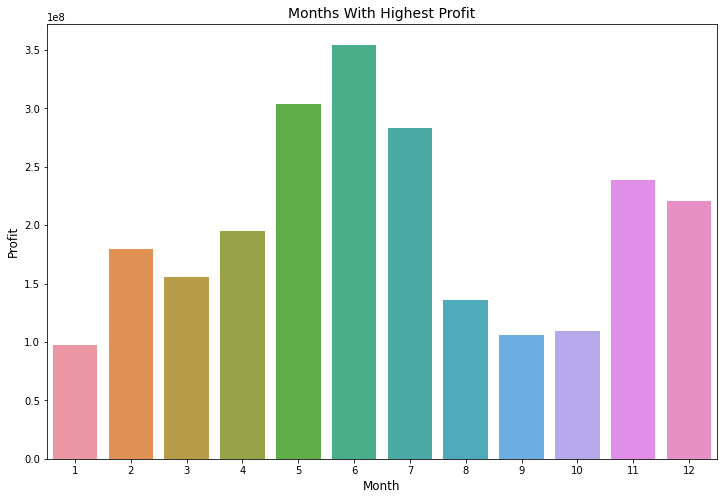

In [137]:
# plotting the data above

fig, ax = plt.subplots(figsize=(12,8))

x = monthly_profit_sum['month']
y = monthly_profit_sum['profit']

sns.barplot(x , y)

ax.set_title('Months With Highest Profit', fontsize=14)
ax.set_xlabel("Month",fontsize=12)
ax.set_ylabel("Profit", fontsize=12)

fig.savefig('Months With Highest Profit.png');

## 4.4 Correlation Analysis

Correlation Analysis is statistical method that is used to discover if there is a relationship between two variables/datasets, and how strong that relationship may be.

It is used to analyse quantitative data to identify whether there is any significant connections, patterns, or trends between two variables.

Since we have numerous variables we will use a heatmap.

In [138]:
# Drop the qualitative data and only remain with columns having quantitative data
movies_df.drop(["movie","genres", "month","original_language","year"], axis = 1, inplace = True)

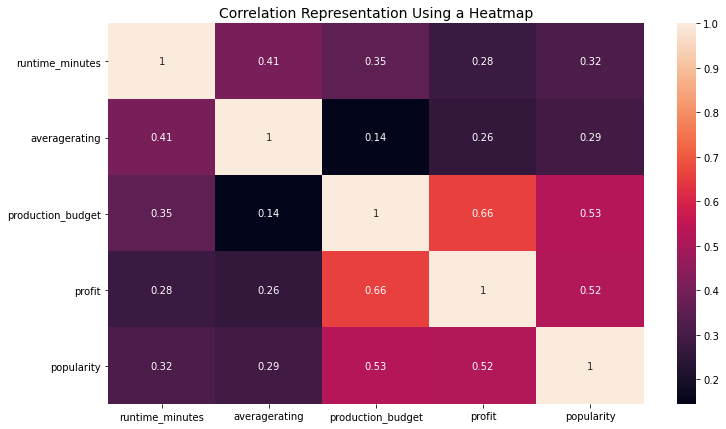

In [139]:
# Python program to generate a heatmap which represents the correlation between columns of panda dataframe

fig, ax = plt.subplots(figsize = (12, 7))
ax.set_title('Correlation Representation Using a Heatmap', fontsize=14)

corr = movies_df.corr()
sns.heatmap(corr, annot = True)

fig.savefig('Correlation Representation Using a Heatmap.png');

Brighter colors indicate a strong relationship while darker colors indicate a weak relationship.

We have positive correlation between all the variables but varying in terms of strength. A positive correlation is a relationship between two variables that tend to move in the same direction. In this case one variable tends to increase when the other increases.

Arranging the variables from the strongest positive correlation to the weakest positive correlation we will have:

Strong Positive Correlation: 
1. Profit and Budget with a correlation of 0.66
2. Popularity and Budget with a correlation of 0.53 
3. Popularity and Profit with a correlation of 0.52.                   

Weak Positive Correlation:

4. Rating and Runtime with a correlation of 0.41 
5. Budget and Runtime with a correlation of 0.35
6. Popularity and Runtime with a correlation of 0.32
7. Popularity and Rating with a correlation of 0.29
8. Runtime and Profit with a correlation of 0.28`
9. Rating and Profit with a correlation of 0.26
10. Rating and Budget with a correlation of 0.14.

# 5. Conclusion

## 5.1 What types of films are doing the best at the box office?

Genre was analysed based on profit, budget, popularity and rating. In order to find out what genres are currently doing well we will combine the top 3 from each this categories. These genres are Adventure, Action, Comedy and Drama. However from the heatmap it is seen that rating has a weak correlation to profit and popularity so we will not base our answer on rating. The higher the budget the higher the popularity as well as the profit. So the top genres (types of films) are Adventure, Action and Comedy. 

## 5.2 Which languages are doing the best at the box office?

Languages were analysed based on profit, popularity , budget and rating. In order to find out what languages are currently doing well we will combine the top 3 from each this categories. These languages are Thai, Telugu, English, Danish,Greek Mordern, Germany  and Spanish. Based on profit and popularity the best language for the films are Thai, Telugu, English. 

## 5.3 Does Release month affect profit?

Yes The Release Month with the highest profit are June, May, July, November and December. School breaks and work vacations fall within these months hence attributing for the profitability of movies on these months. 

## 5.4 Is there a correlation between runtime minutes and the other variables?

No, runtime minutes for a film has a weak positive correlation on the quantitative variables hence we can not use it for our analysis. Runtime minutes for the film do not affect its profitability or popularity strongly hence the minutes can vary. This will therefore not be added to recommendations.

# 6. Recommendation

1. The best types of films to create are Adventure, Action and Comedy
2. The best languages for this films are Thai, Telugu and English
3. The best months to release the films are June, May and July.